<a href="https://colab.research.google.com/github/JacekPardyak/inkscape.py.data/blob/master/dcgan_svg_linestring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [69]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.13.0'

In [3]:
!pip install svgpathtools

In [4]:
import os
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [6]:
import os
import glob
import numpy as np
from svgpathtools import wsvg, disvg, svg2paths, concatpaths, Line, Path, CubicBezier

DATA_DIR = tf.keras.utils.get_file(
    "mnist.svg.zip",
    "https://github.com/JacekPardyak/inkscape.py.data/raw/master/mnist.svg.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "mnist.svg")

def point_encoder(file, num):
  paths, attributes = svg2paths(file)
  paths = concatpaths(paths)
  length = paths.length()
  paths = paths.continuous_subpaths()
  l = [path.length()/length for path in paths]
  targets = [num*v for v in l]
  nums = [ int(v) for v in targets]
  while sum(nums) < num:
    residuals = [ t - v for t,v in zip(targets, nums) ]
    index = residuals.index( max(residuals) )
    nums[index] += 1
  output = np.empty((0,4), int)
  index = 0
  for path in paths:
    points = np.array([path.point(pos = x) for x in np.linspace(0, 1, num=nums[index], endpoint=False)])
    tmp = np.column_stack((points.real, points.imag))
    tmp = np.column_stack((tmp, np.roll(tmp, -1, axis=0)))
    output = np.row_stack((output, tmp))
    index = index + 1
  return output

def point_decoder(tens):
  path = Path()
  for i in range(tens.shape[0] ):
    row = Line(complex(tens[i,0], tens[i,1]), complex(tens[i,2], tens[i,3]))
    path.append(row)
  return path

def parse_dataset(num_points):
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map = {}
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
  folders
  for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
#        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        for f in train_files:
            train_points.append(point_encoder(file = f, num = num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(point_encoder(file = f, num = num_points))
            test_labels.append(i)
  return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )
NUM_CURVES = 32 # 31 is max in data

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_CURVES
)


processing class: 7
processing class: 1
processing class: 9
processing class: 2
processing class: 4
processing class: 5
processing class: 3
processing class: 6
processing class: 0
processing class: 8


In [7]:
from IPython.display import SVG, display
file = os.path.join(DATA_DIR, "0/test/0_60003.svg")
#file = os.path.join(DATA_DIR, "1/test/1_60002.svg")
file = os.path.join(DATA_DIR, "8/test/8_60233.svg")
display(SVG(filename = file))

In [8]:
points = point_encoder(file = file, num = NUM_CURVES)
points

array([[110.        , 211.        ,  82.4894019 , 201.29161049],
       [ 82.4894019 , 201.29161049,  73.2814086 , 185.57144719],
       [ 73.2814086 , 185.57144719,  82.61479753, 164.43645363],
       [ 82.61479753, 164.43645363, 107.98908083, 139.61853828],
       [107.98908083, 139.61853828, 125.56211536, 114.10424919],
       [125.56211536, 114.10424919, 129.63810487,  90.45008769],
       [129.63810487,  90.45008769, 118.91995949,  74.28351262],
       [118.91995949,  74.28351262, 110.25490441,  50.46213949],
       [110.25490441,  50.46213949, 120.05587849,  26.26240661],
       [120.05587849,  26.26240661, 142.93458239,  24.09391196],
       [142.93458239,  24.09391196, 168.16445644,  35.23332147],
       [168.16445644,  35.23332147, 178.25460314,  53.28547098],
       [178.25460314,  53.28547098, 176.37559495,  85.55113931],
       [176.37559495,  85.55113931, 178.16976244, 110.4128317 ],
       [178.16976244, 110.4128317 , 189.19013015, 131.39595142],
       [189.19013015, 131

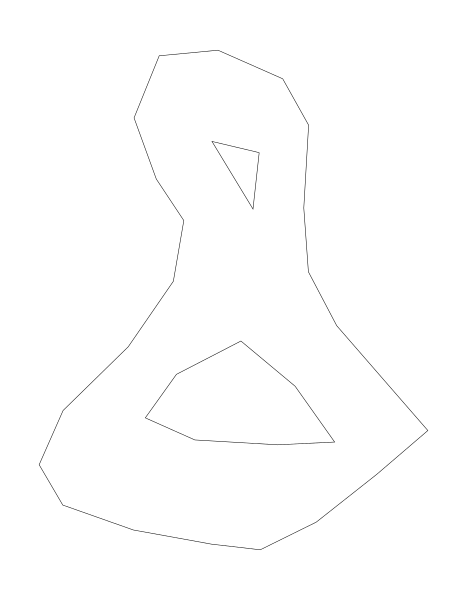

In [9]:
path = point_decoder(points)
wsvg(paths = path, filename = "disvg_output.svg", openinbrowser=False)
display(SVG(filename = "disvg_output.svg"))

In [10]:
train_points.shape

(60000, 32, 4)

In [80]:
#train_images.shape

In [11]:
a = 140
b = 140
train_images = train_points.reshape(train_points.shape[0], NUM_CURVES, 4, 1).astype('float32')
train_images = (train_images - a) / b # Normalize the images to [-1, 1]

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 4, 1), dtype=tf.float32, name=None)>

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(int(NUM_CURVES/4) * 1 *256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(NUM_CURVES/4) , 1, 256)))
    assert model.output_shape == (None, int(NUM_CURVES/4), 1, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int(NUM_CURVES/4), 1, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int(NUM_CURVES/2), 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, NUM_CURVES, 4, 1)

    return model

In [85]:
# 7*7*256 = 12544       | 8 * 1 * 256
# (None, 7, 7, 256)     | (None, 8, 1, 256)
# (None, 7, 7, 128)     | (None, 8, 1, 128)
# (None, 14, 14, 64)    | (None, 16, 2, 64)
# (None, 28, 28, 1)     | (None, 32,  4, 1)


Failed to open output SVG in browser.  SVG saved to:
disvg_output.svg


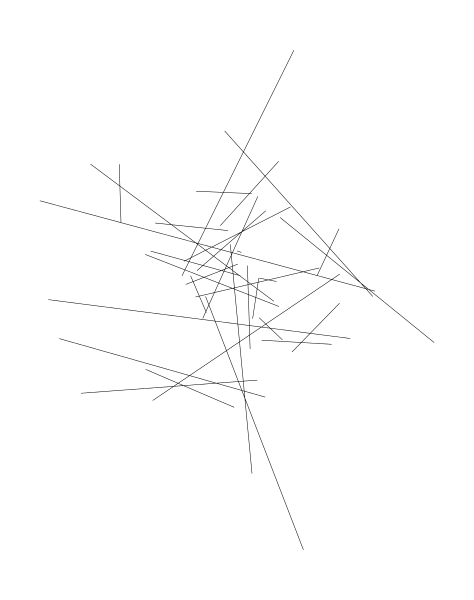

In [15]:
from svgpathtools import disvg
from IPython.display import SVG, display
noise = tf.random.normal([1, 100])
generator = make_generator_model()
generated_image = generator(noise, training=False)
path = point_decoder(tens = tf.reshape(generated_image,[NUM_CURVES,4]))

disvg(path, filename = "disvg_output.svg")
display(SVG(filename = "disvg_output.svg"))

### The Discriminator

The discriminator is a CNN-based image classifier.

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[NUM_CURVES, 4, 1])) # <-
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0001929]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #4

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [23]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 1 # było 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce SVG images for the animated SVG as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  #fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      #plt.subplot(4, 4, i+1)
      path = point_decoder(tens = tf.reshape(predictions[i, :, :, 0],[NUM_CURVES,4]) * b + a)
      disvg(path, filename = "disvg_output.svg")

  disvg(path, filename = 'image_at_epoch_{:04d}.svg'.format(epoch))

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_dataset, EPOCHS)

Failed to open output SVG in browser.  SVG saved to:
disvg_output.svg
Failed to open output SVG in browser.  SVG saved to:
image_at_epoch_0001.svg
Time for epoch 1 is 182.65867614746094 sec
Failed to open output SVG in browser.  SVG saved to:
disvg_output.svg
Failed to open output SVG in browser.  SVG saved to:
image_at_epoch_0002.svg
Time for epoch 2 is 180.0632963180542 sec
Failed to open output SVG in browser.  SVG saved to:
disvg_output.svg
Failed to open output SVG in browser.  SVG saved to:
image_at_epoch_0003.svg
Time for epoch 3 is 179.67467045783997 sec
Failed to open output SVG in browser.  SVG saved to:
disvg_output.svg
Failed to open output SVG in browser.  SVG saved to:
image_at_epoch_0004.svg
Time for epoch 4 is 180.06836128234863 sec


Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create an animated SVG


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return display(SVG(filename = 'image_at_epoch_{:04d}.svg'.format(epoch_no)))

In [ ]:
display_image(EPOCHS)

Use `xml` to create an animated svg using the images saved during training.

In [ ]:
import os
import xml.etree.ElementTree as ET
#EPOCHS = 7
ET.register_namespace('', "http://www.w3.org/2000/svg")
# first file
files = ['image_at_epoch_{:04d}.svg'.format(epoch_no) for epoch_no in range(1, EPOCHS+1)]

master_tree = ET.parse(files[0])
master_root = master_tree.getroot()
master_root.remove(master_root[1])
master_root[0].text = '\nCreated by JG Pardyak\n'
#print(ET.tostring(master_root, 'utf-8'))
master_root = master_tree.getroot()
master_root.attrib['width'] = '600px'
master_root.attrib['height'] = '600px'
master_root.attrib['viewBox'] = '0 0 600 600'

i = 0
for file in files:
  tree = ET.parse(file)
  root = tree.getroot()
  child = ET.Element('{http://www.w3.org/2000/svg}g')
  root.append(child)
  root[2].append(root[1])
  root.remove(root[1])
  root[1].set('opacity', '0')
  ET.SubElement(root[1], '{http://www.w3.org/2000/svg}animate')
  root[1][1].set('attributeName', 'opacity')
  root[1][1].set('from', '0')
  root[1][1].set('to', '1')
  root[1][1].set('begin', str(4 * i) +'s')
  root[1][1].set('dur', '2s')
  root[1][1].set('fill', 'freeze')
  ET.SubElement(root[1], '{http://www.w3.org/2000/svg}animate')
  root[1][2].set('attributeName', 'opacity')
  root[1][2].set('from', '1')
  root[1][2].set('to', '0')
  root[1][2].set('begin', str(4 * i + 2) +'s')
  root[1][2].set('dur', '2s')
  root[1][2].set('fill', 'freeze')
  master_root.append(root[1])
  i = i + 1


master_tree.write('output.svg')

In [ ]:
display(SVG(filename = 'output.svg'))

In [ ]:
import os
import xml.etree.ElementTree as ET
#EPOCHS = 7
files = ['image_at_epoch_{:04d}.svg'.format(epoch_no) for epoch_no in range(1, EPOCHS+1)]
nfiles = len(files)
ncol = 3
nrow = 3

new_width = ncol * 300
new_height = nrow * 300

master_tree = ET.parse(files[0])
master_root = master_tree.getroot()
master_root.remove(master_root[1])

master_root.set('width', f'{new_width}px')
master_root.set('height', f'{new_height}px')
master_root.set('viewBox', f'0 0 {new_width} {new_height}')
master_root.get('width')

count = -1
for row in range(nrow):
  for col in range(ncol):
    count = count + 1
    if count == nfiles:
      break
    pos = [col * 300, (row + 1) * 300]
    print(row, col, count, pos)
    tree = ET.parse(files[count])
    root = tree.getroot()
    root[1].set('transform', f'translate({pos[0]},{pos[1]}) scale(1,-1)')
    root[1].get('transform')
    master_root.append(root[1])

master_tree.write('grid.svg')


In [ ]:
display(SVG(filename = 'grid.svg'))

In [ ]:
#disvg(paths, filename = "disvg_output.svg")
#display(SVG(filename = "disvg_output.svg"))

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
